# Deep Q-Network implementation

This notebook implements a DQN - an approximate Q-learning algorithm with experience replay and target networks. It trains the algorithm on openAI's gym, on the breakout Atari game, and monitors its games by exporting videos.

This notebook is very advanced, as it trains an agent to play a game without prior knowledge.
The agent takes in the pixels of the game as input, and then uses its algorithm (DQN) in order to process the state space and come up with the optimal action for the game to maximize reward.

Original code by [GiannisMitr](https://github.com/GiannisMitr/DQN-Atari-Breakout/blob/master/dqn_atari_breakout.ipynb), updated for Tensorflow v2 and simplified/optimized by Chong Min


# Install Pre-requisites/Dependencies

The following dependencies are required to get the gym environment working and also to display the gym environment as a video

In [1]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (51.0.0)


# Configure Colab to display video of our agent!

The code below simply configures Colab to display a video of the environment for us to visualize.

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
import numpy as np
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Understanding the state space

The state space will be the raw Atari pixels. In order to encode velocity information, we take the last four frames of the game as the state space.

### State Space Processing (Part 1): Downsizing the Atari pixels

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [5]:
from gym.core import ObservationWrapper
from gym.spaces import Box

# from scipy.misc import imresize
import cv2

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""
        
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
        
        # resize image
        img = cv2.resize(img, self.img_size)
        
        img = img.mean(-1,keepdims=True)
        
        img = img.astype('float32') / 255.
              
        return img


### State Space Processing (Part 2): Frame buffer

Our agent can only process one observation at a time, so we have got to make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images.


In [6]:
from gym.spaces.box import Box
from gym.core import Wrapper
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            """Multiply channels dimension by number of frames"""
            obs_shape = [height, width, n_channels * n_frames] 
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        s = self.env.reset()
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(s)
        return self.framebuffer
    
    def step(self, action):
        """Play the action and update the buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,offset:]
        self.framebuffer = np.concatenate([cropped_framebuffer, img], axis = axis)


In [7]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

#Instatntiate gym Atari-Breakout environment
env = make_env()
env.reset()
    
#take away the noop action and the fire button to make learning faster
n_actions = env.action_space.n
state_dim = env.observation_space.shape

### Visualizing the first 4 steps of the game with random actions

Game Time step 0 Action: NOOP  Reward: 0.0 Has completed: False Information: {'ale.lives': 5}
Game Time step 1 Action: LEFT  Reward: 0.0 Has completed: False Information: {'ale.lives': 5}
Game Time step 2 Action: LEFT  Reward: 0.0 Has completed: False Information: {'ale.lives': 5}
Game Time step 3 Action: RIGHT  Reward: 0.0 Has completed: False Information: {'ale.lives': 5}


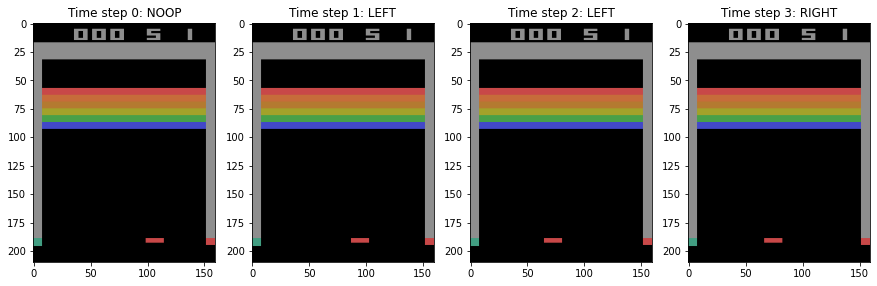

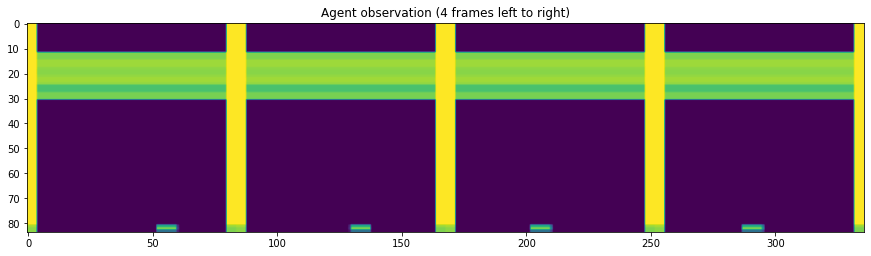

In [8]:
env.reset()

move = {0:'NOOP', 1:'FIRE', 2: 'RIGHT', 3: 'LEFT'}
numsteps = 4
fig, ax = plt.subplots(1, numsteps, figsize = (15, 6))
for t in range(numsteps):
    a = env.action_space.sample()
    obs, reward, done, info = env.step(a)
    ax[t].set_title("Time step "+str(t)+': '+move[a])
    ax[t].imshow(env.render("rgb_array"))
    print('Game Time step', t, 'Action:', move[a], ' Reward:', reward, 'Has completed:', done, 'Information:', info)
    
plt.figure(figsize = (15, 6))
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]))

### Understanding the actions
- 0: NOOP (No action)
- 1: FIRE (Start button to get the ball moving)
- 2: RIGHT (Moves paddle to the right)
- 3: LEFT (Moves paddle to the left)

These moves will be called by env.step(action = 0), env.step(action = 1), env.step(action = 2), env.step(action = 3).

We will perform these actions for a maximum of 1000 time steps, so as to make training faster.

In [9]:
# get the actions
print('Available actions:', list(zip(enumerate(env.unwrapped.get_action_meanings()))))

Available actions: [((0, 'NOOP'),), ((1, 'FIRE'),), ((2, 'RIGHT'),), ((3, 'LEFT'),)]


### Understanding the reward
The reward for this game is fairly simple.

For each time step:
- Brick destroyed: Reward +1
- Other: Reward +0

At the end of the game (when all bricks are destroyed or the player loses all lives), we will take the total accumulated reward.

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be a huge neural network unless we have an array of GPUs for processing. Instead, we can use strided convolutions with a small number of features to save time and memory.

In [10]:
#Import TensorFlow and Keras
import tensorflow.compat.v1 as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer

# the code is mainly written with non-dynamic flow graph of tensorflow v1, so disable eager execution
tf.disable_eager_execution()
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [11]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            self.network = keras.models.Sequential()
            # Keras ignores the first dimension in the input_shape, which is the batch size. 
            # So just use state_shape for the input shape
            self.network.add(Conv2D(32, (8, 8), strides=4, activation='relu',use_bias=False, input_shape=state_shape,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (4, 4), strides=2, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (3, 3), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(1024, (7, 7), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Flatten())
            self.network.add(Dense(n_actions, activation='linear',kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [12]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every 20 iterations.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$




In [13]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [14]:
def load_weights_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)
    


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

In [15]:
# Create placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [16]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [17]:
# compute q-values for NEXT states with target network
next_qvalues_target =  target_network.get_symbolic_qvalues(next_obs_ph)

# compute state values by taking max over next_qvalues_target for all actions
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

# Define loss function for sgd.
# td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(tf.losses.huber_loss(labels=reference_qvalues, predictions=current_action_qvalues))

optimizer=tf.train.AdamOptimizer(1e-5)
train_step = optimizer.minimize(td_loss, var_list=agent.weights)

sess.run(tf.global_variables_initializer())

### Experience replay
#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [18]:
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        self._storage.append(data)
        self._storage = self._storage[-self._maxsize:]

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


In [19]:
def play_and_record(agent, env, exp_replay, n_games=1, t_max = 1000):
    """
    Play games n_games number of times, record every transition (s,a,r,s', done) to replay buffer. 
    :returns: return sum of rewards over time
    """
    
    # Play the game for n_steps as per instructions above
    reward = 0.0
    for i in range(n_games):
        s = env.reset()
        for t in range(t_max):
            # get agent to pick action given state s
            qvalues = agent.get_qvalues([s])
            action = agent.sample_actions(qvalues)[0]
            next_s, r, done, _ = env.step(action)

            # add to replay buffer
            exp_replay.add(s, action, r, next_s, done)
            reward += r
            if done:
                break
            else:
                s = next_s
    return reward

### Visualize the experience replay buffer

In [20]:
#Create the buffer and fill it.
exp_replay = ReplayBuffer(10000)
reward = play_and_record(agent, env, exp_replay, n_games = 10)

# reset agent till more than 20% of games hits a brick, this helps neural network training later
while reward < 2:
    agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
    sess.run(tf.global_variables_initializer())
    exp_replay = ReplayBuffer(10000)
    reward = play_and_record(agent, env, exp_replay, n_games = 10)
print(reward)

# take a sample batch of observations from the buffer
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

52.0


In [21]:
# View the length of the replay buffer
len(exp_replay)

2651

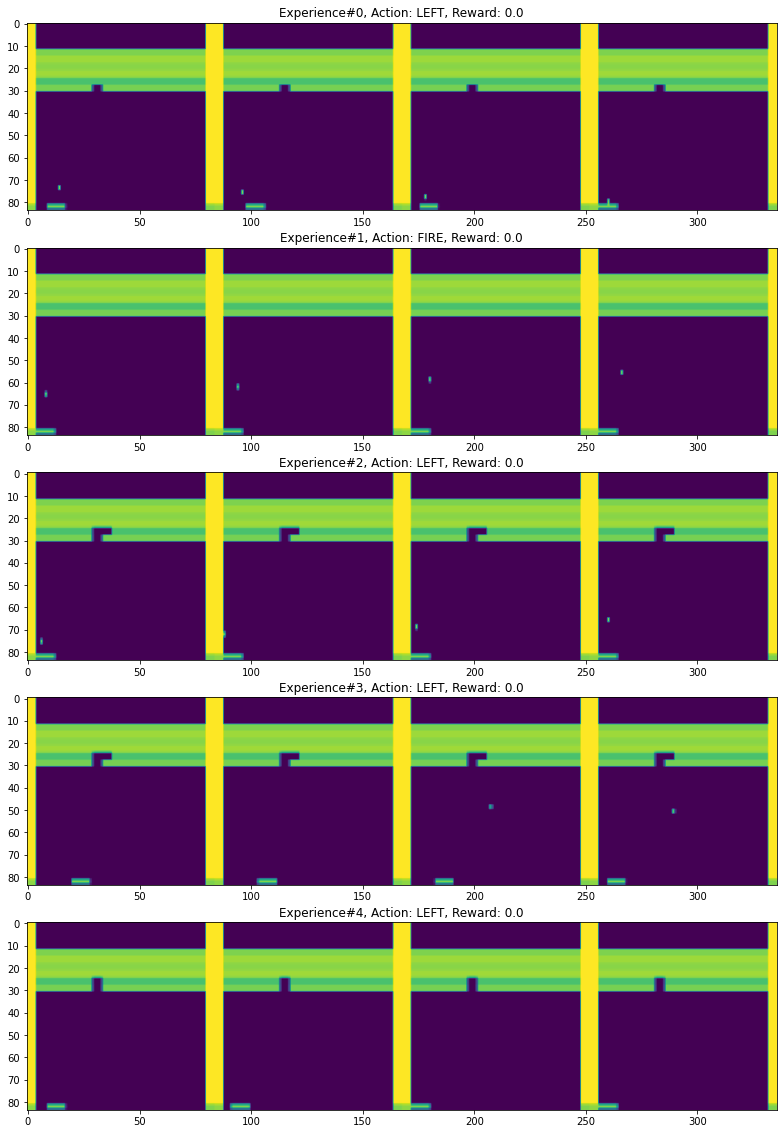

In [22]:
# Adjust this value to view number of samples randomly from the experience buffer
numsamples = 5
samples = sample_batch(exp_replay, numsamples)

obs, action, reward = samples[next_obs_ph], samples[actions_ph], samples[rewards_ph]
fig, ax = plt.subplots(numsamples, 1, figsize = (15, 4*numsamples))
for row in range(numsamples):
    i = row
    ax[row].set_title('Experience#' + str(i) + ', Action: ' + str(move[action[i]]) + ', Reward: '+str(reward[i]))
    ax[row].imshow(obs[i].transpose([0,2,1]).reshape([state_dim[0],-1]))

### Main loop

It's time to put everything together and see if it learns anything.

In [23]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

buffer size = 10000, epsilon = 0.07694
Iteration number: 980


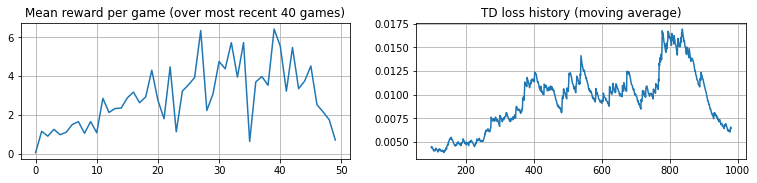

100%|██████████| 1000/1000 [19:30<00:00,  1.17s/it]


In [24]:
##Train the agent, configure the starting epsilon to one to encourage exploration
agent.epsilon=1

# initialize the reward and loss lists
mean_rw_history = []
td_loss_history = []

totalreward = 0

for i in trange(1000):
    
    # play two games and record the outcome
    totalreward += play_and_record(agent, env, exp_replay, 2)

    # train the network
    # sample a batch_size number of experiences from replay buffer to do training on
    # calculate the loss
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # update target network every 20 iterations
    if i % 20 == 0:
        load_weights_into_target_network(agent, target_network)
        agent.network.save_weights('dqn_model_atari_weights_new.h5')
        # reduce epsilon in every iteration until it reaches 1%
        agent.epsilon = max(agent.epsilon * 0.95, 0.01)
    
    if i % 20 == 0:
        mean_rw_history.append(totalreward/40)
        totalreward = 0
        
    if i % 20 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        print("Iteration number:", i)
        
        plt.figure(figsize=[13, 2.5])
        plt.subplot(1,2,1)
        plt.title("Mean reward per game (over most recent 40 games)")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

        

__ How to interpret plots: __


This is not supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE/Huber Loss between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 500+ iterations to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.


__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's going start winning (average reward > 10) after 1000 iterations.

If at the end of 1000 iterations the agent still has not learnt well, simply rerun the above code again, so that epsilon can be reset to 1 for random exploration. Do it for as many times as it takes for the agent to learn something useful.

### Visualize Agent Performance

In [28]:
import gym
import time
import tensorflow.compat.v1 as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer

#Instatntiate gym Atari-Breakout environment
env = wrap_env(make_env())

## Uncomment this if you want to use your previously saved weights
# agent.network.load_weights('dqn_model_atari_weights_new.h5')

s = env.reset()
totalreward = 0
for t in range(1000):
    qvalues = agent.get_qvalues([s])
    # select greedy action
    action = qvalues.argmax(axis=-1)[0]
    next_s, r, done, _ = env.step(action)  
    totalreward += r
    s = next_s
    env.render()
    if done:
        print("Episode finished after {} timesteps with reward {}".format(t+1, totalreward))
        break
env.close()
show_video()